<a href="https://colab.research.google.com/github/N2000-hack/Music_Genre_Classification_Project/blob/main/music_genre_classification_xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**IMPORTING LIBRARIES**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import warnings
warnings.simplefilter("ignore", UserWarning)

!pip install xgboost -U
!pip install librosa -U
!pip install hyperopt

import os
from tqdm import tqdm
import pickle
import scipy
import sys
import pandas as pd
import numpy as np
import IPython
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import librosa #Python package for music & audio files
import librosa.display
import librosa.display as lplt

from tensorflow import keras
from keras.models import Sequential
from IPython.display import Audio
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize
from sklearn.feature_selection import RFECV,mutual_info_regression
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 192.9 MB 47 kB/s 
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 213 kB 9.0 MB/s 
  Attempting uninstall: librosa
    Found existing installation: librosa 0.8.1
    Uninstalling librosa-0.8.1:
      Successfully uninstalled librosa-0.8.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**LOADING & PREPROCESSING THE DATA**

In [ ]:
#Reading the csv file
final_data = pd.read_csv("/content/drive/MyDrive/Data (1)/features_3_sec.csv")

In [ ]:
final_data.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [ ]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9990 entries, 0 to 9989
Data columns (total 60 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   filename                 9990 non-null   object 
 1   length                   9990 non-null   int64  
 2   chroma_stft_mean         9990 non-null   float64
 3   chroma_stft_var          9990 non-null   float64
 4   rms_mean                 9990 non-null   float64
 5   rms_var                  9990 non-null   float64
 6   spectral_centroid_mean   9990 non-null   float64
 7   spectral_centroid_var    9990 non-null   float64
 8   spectral_bandwidth_mean  9990 non-null   float64
 9   spectral_bandwidth_var   9990 non-null   float64
 10  rolloff_mean             9990 non-null   float64
 11  rolloff_var              9990 non-null   float64
 12  zero_crossing_rate_mean  9990 non-null   float64
 13  zero_crossing_rate_var   9990 non-null   float64
 14  harmony_mean            

In [ ]:
final_data.shape

(9990, 60)

In [ ]:
final_data.dtypes

filename                    object
length                       int64
chroma_stft_mean           float64
chroma_stft_var            float64
rms_mean                   float64
rms_var                    float64
spectral_centroid_mean     float64
spectral_centroid_var      float64
spectral_bandwidth_mean    float64
spectral_bandwidth_var     float64
rolloff_mean               float64
rolloff_var                float64
zero_crossing_rate_mean    float64
zero_crossing_rate_var     float64
harmony_mean               float64
harmony_var                float64
perceptr_mean              float64
perceptr_var               float64
tempo                      float64
mfcc1_mean                 float64
mfcc1_var                  float64
mfcc2_mean                 float64
mfcc2_var                  float64
mfcc3_mean                 float64
mfcc3_var                  float64
mfcc4_mean                 float64
mfcc4_var                  float64
mfcc5_mean                 float64
mfcc5_var           

In [ ]:
final_data = final_data.drop(labels='filename',axis=1)

In [ ]:
#audio file
audio = "/content/drive/MyDrive/Data/blues.00004.wav"
#Load & decode the audio as a time series, where sr represents the sampling rate
data , sr = librosa.load(audio)
print(type(data), type(sr))

<class 'numpy.ndarray'> <class 'int'>


In [ ]:
librosa.load(audio, sr=45600)

(array([-0.00625101, -0.00872423, -0.00935522, ...,  0.06243865,
         0.05244213,  0.02609423], dtype=float32), 45600)

In [ ]:
#Playing the audio within the notebook
IPython.display.Audio(data, rate=sr)

**AUDIO VISUALIZATION**

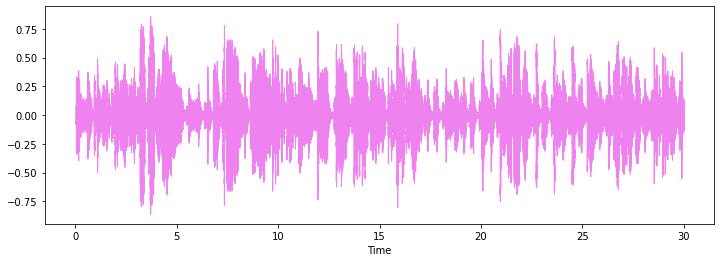

In [ ]:
#Plotting the raw wave file to quickly scan the audio data & contrast which genres might be more similar.

plt.figure(figsize=(12,4))
librosa.display.waveshow(data, color = "Violet")
plt.show()

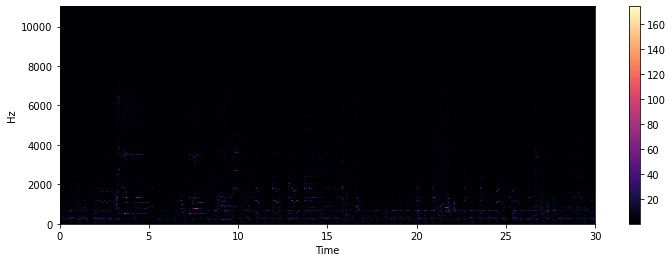

In [ ]:
#Spectrogram
stft = librosa.stft(data)
stft_db = librosa.amplitude_to_db(abs(stft))
plt.figure(figsize=(12,4))
librosa.display.specshow(stft, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()


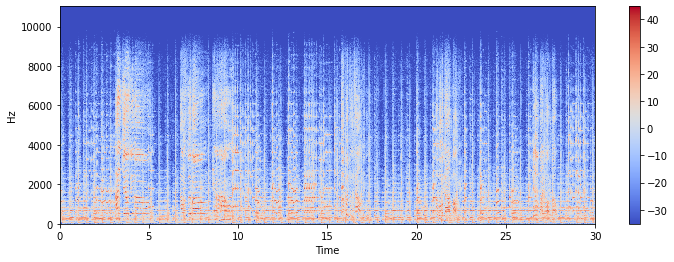

In [ ]:
#DB-SCALED SPECTOGRAM
stft = librosa.stft(data)
stft_db = librosa.amplitude_to_db(abs(stft))
plt.figure(figsize=(12,4))
librosa.display.specshow(stft_db, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Pass y=[0.00368286 0.00072266 0.0016687  ... 0.05135132 0.06197143 0.06496216] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  


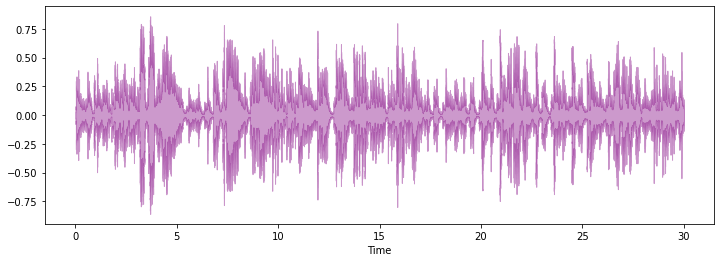

In [ ]:
#computing the rolloff frequency for each frame in a signal
spectral_rolloff = librosa.feature.spectral_rolloff(data+0.01, sr=sr)[0]
plt.figure(figsize=(12,4))
librosa.display.waveshow(data, sr=sr, alpha=0.4, color='Purple')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Pass y=[-0.00631714 -0.00927734 -0.0083313  ...  0.04135132  0.05197144
  0.05496216] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  This is separate from the ipykernel package so we can avoid doing imports until


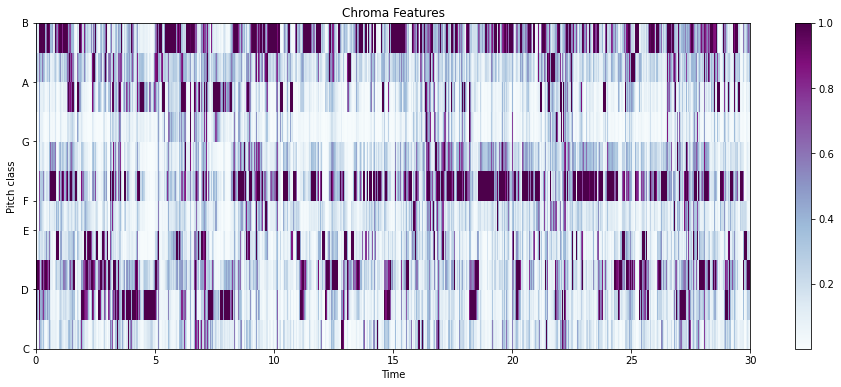

In [ ]:
#Chroma feature or chromagram closely relates to the twelve different pitch classes.
#Chroma features capture harmonic & melodic characteristics of music while being robust to changes.
chroma = librosa.feature.chroma_stft(data, sr=sr)
plt.figure(figsize=(16,6))
lplt.specshow(chroma, sr=sr, x_axis='time', y_axis='chroma', cmap='BuPu')
plt.colorbar()
plt.title("Chroma Features")
plt.show()

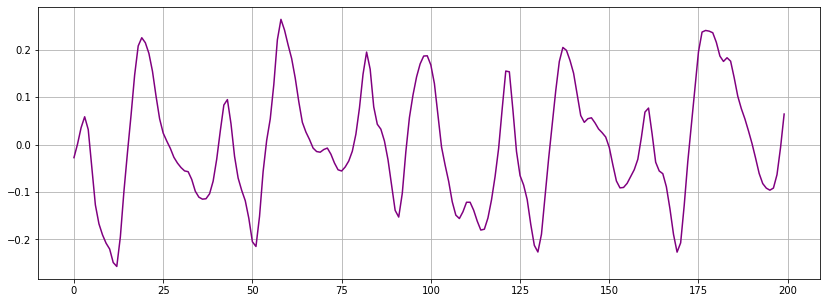

In [ ]:
#The rate at which zero-crossings occur is a simple measure of the frequency content of a signal.
#Zero crossing is said to occur if successive samples have different algebric signs.
start = 1000
end = 1200
plt.figure(figsize=(14,5))
plt.plot(data[start:end], color='Purple')
plt.grid()

In [ ]:
zero_cross_rate = librosa.zero_crossings(data[start:end], pad=False)
print("The number of zero crossings is:",sum(zero_cross_rate))

The number of zero crossings is: 21


**EXTRACTING AND SCALING THE FEATURES**

In [ ]:
#To convert categorical data into model-understandable numerica data
class_list = final_data.iloc[:, -1]
convertor = LabelEncoder()

In [ ]:
#Fitting the label encoder & return encoded labels
y = convertor.fit_transform(class_list)

In [ ]:
y

array([0, 0, 0, ..., 9, 9, 9])

In [ ]:
print(final_data.iloc[:, :-1])

      length  chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
0      66149          0.335406         0.091048  0.130405  0.003521   
1      66149          0.343065         0.086147  0.112699  0.001450   
2      66149          0.346815         0.092243  0.132003  0.004620   
3      66149          0.363639         0.086856  0.132565  0.002448   
4      66149          0.335579         0.088129  0.143289  0.001701   
...      ...               ...              ...       ...       ...   
9985   66149          0.349126         0.080515  0.050019  0.000097   
9986   66149          0.372564         0.082626  0.057897  0.000088   
9987   66149          0.347481         0.089019  0.052403  0.000701   
9988   66149          0.387527         0.084815  0.066430  0.000320   
9989   66149          0.369293         0.086759  0.050524  0.000067   

      spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
0                1773.065032          167541.630869              19

In [ ]:
#Standard scaler is used to standardize features & look like standard normally distributed data
fit = StandardScaler()
X = fit.fit_transform(np.array(final_data.iloc[:, :-1], dtype = float))

**SPLIT THE DATA INTO TRAINING DATA & TEST DATA**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [ ]:
len(y_train)

6693

In [ ]:
len(y_test)

3297

In [ ]:
#The loss is calculated using sparse_categorical_crossentropy function
def trainModel(model, epochs, optimizer):
    batch_size = 128
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                   metrics='accuracy'
    )
    return model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs,
                     batch_size=batch_size)

In [ ]:
#Plotting the curves
def plotValidate(history):
    print("Validation Accuracy",max(history.history["val_accuracy"]))
    pd.DataFrame(history.history).plot(figsize=(12,6))
    plt.show()


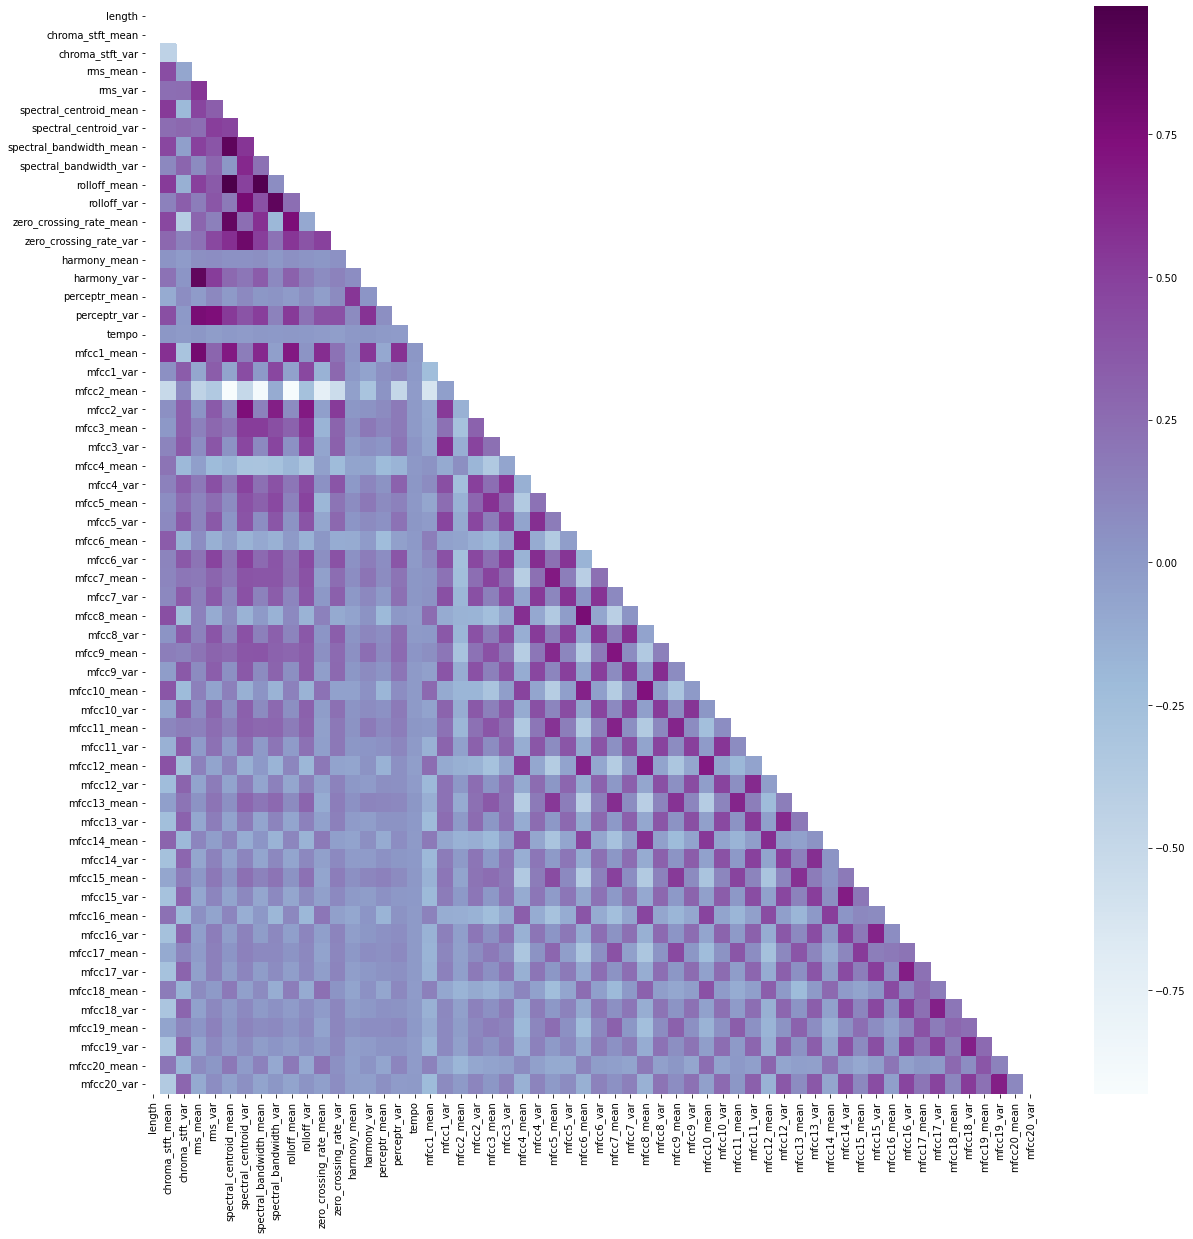

In [ ]:
#correlation
corr = final_data.corr()
#Creation of a mask for the heatmap
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.subplots(figsize=(20, 20))
sns.heatmap(corr, mask=mask, cmap="BuPu")

**XGBOOST**

* XGBoost (eXtreme Gradient Boosting) is a popular supervised-learning algorithm used for regression and classification on large datasets. It uses sequentially-built shallow decision trees to provide accurate results and a highly-scalable training method that avoids overfitting.

* XGBClassifier is a scikit-learn API compatible class for classification.

In [ ]:
model = XGBClassifier(n_estimators=1000)
model.fit(X_train,y_train,eval_metric='merror')

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [ ]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
target_names = sorted(set(y))

print(f'Training accuracy: {accuracy_score(y_train,y_pred_train)}')
print(f'Training:\n {classification_report(y_train, y_pred_train, labels=target_names)}')
print(f'Testing accuracy: {accuracy_score(y_test,y_pred_test)}')
print(f'Testing:\n {classification_report(y_test, y_pred_test, labels=target_names)}')

Training accuracy: 0.9992529508441655
Training:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       703
           1       1.00      1.00      1.00       662
           2       1.00      1.00      1.00       687
           3       1.00      1.00      1.00       669
           4       1.00      1.00      1.00       676
           5       1.00      1.00      1.00       655
           6       0.99      1.00      1.00       671
           7       1.00      1.00      1.00       676
           8       1.00      1.00      1.00       646
           9       1.00      0.99      1.00       648

    accuracy                           1.00      6693
   macro avg       1.00      1.00      1.00      6693
weighted avg       1.00      1.00      1.00      6693

Testing accuracy: 0.8938428874734607
Testing:
               precision    recall  f1-score   support

           0       0.88      0.90      0.89       297
           1       0.93      0.96   

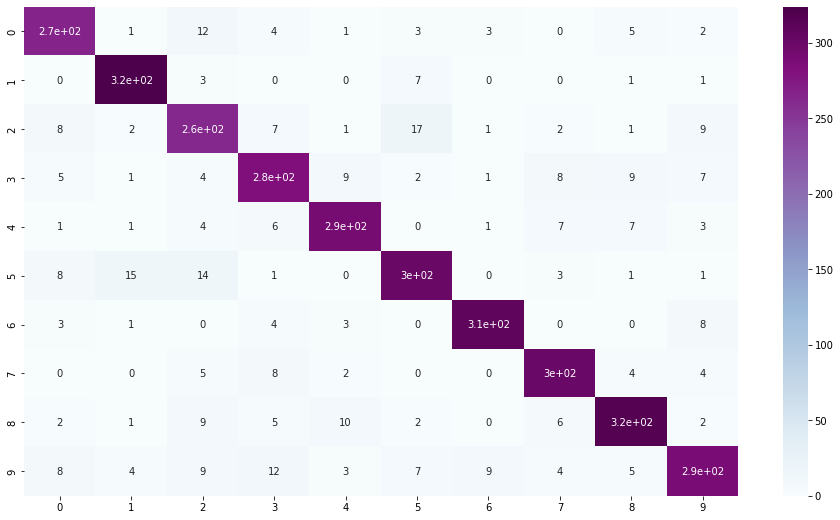

In [ ]:
#Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize = (16, 9))
sns.heatmap(conf_mat,cmap="BuPu", annot=True, xticklabels = target_names, yticklabels = target_names )